In [ ]:
# Install required libraries
!pip install -q transformers[torch] datasets accelerate evaluate scikit-learn

import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import torch

print("Setup Complete. GPU Available:", torch.cuda.is_available())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
Setup Complete. GPU Available: True


In [ ]:
# Load your original dataset
df = pd.read_csv('House Price Prediction Dataset.csv')

# 1. Augment with 'Month_of_Sale' (1-12) to meet your specific requirement
np.random.seed(42)
df['Month_of_Sale'] = np.random.randint(1, 13, size=len(df))

# 2. Simulate seasonal pricing (Summer months June-August get a 10% boost)
# This gives the model a pattern to "learn" during fine-tuning.
df['Price'] = df.apply(lambda x: x['Price'] * 1.1 if x['Month_of_Sale'] in [6, 7, 8] else x['Price'], axis=1)

# 3. Format into a Prompt for the LLM
def create_prompt(row):
    text = f"Instruction: Predict the house price.\n"
    text += f"Input: Area: {row['Area']}sqft, {row['Bedrooms']}BR, {row['Bathrooms']}BA, Location: {row['Location']}, Condition: {row['Condition']}, Month of Sale: {row['Month_of_Sale']}\n"
    text += f"Response: The estimated price is ${int(row['Price'])}."
    return {"text": text}

# 4. Clean and Split (80% Train, 10% Val, 10% Test)
dataset = Dataset.from_pandas(df.apply(create_prompt, axis=1, result_type='expand'))
train_testvalid = dataset.train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

print(f"Data Prepared. Training size: {len(ds['train'])}")

Data Prepared. Training size: 1600


In [ ]:
model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token # GPT-2 doesn't have a pad token by default

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_ds = ds.map(tokenize_function, batched=True)
print("Tokenization Complete.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenization Complete.


In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id)

def test_model(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=20)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

sample_prompt = ds['test'][0]['text'].split("Response:")[0] + "Response:"
print("--- Baseline Model Prediction ---")
test_model(sample_prompt)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


--- Baseline Model Prediction ---
Instruction: Predict the house price.
Input: Area: 4899sqft, 3BR, 4BA, Location: Downtown, Condition: Fair, Month of Sale: 11
Response:
The house price is a good indicator of the market's value. The price of a house is


In [ ]:
# Strategy: Using a small learning rate and weight decay to prevent overfitting
# Add a data collator to handle the labels for causal language modeling
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./house_price_model",
    eval_strategy="epoch",  # Log results at every epoch
    learning_rate=5e-5,      # Test 1: Standard LR
    per_device_train_batch_size=4,
    num_train_epochs=3,      # Fast enough for 3-hour limit
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=1,
)

# Prepare the dataset by ensuring 'labels' are present
def add_labels(examples):
    examples["labels"] = examples["input_ids"]
    return examples

tokenized_ds_with_labels = tokenized_ds.map(add_labels, batched=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds_with_labels["train"],
    eval_dataset=tokenized_ds_with_labels["valid"],
    data_collator=data_collator # Add the data collator
)

print("Starting Fine-Tuning...")
trainer.train()

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Starting Fine-Tuning...


Epoch,Training Loss,Validation Loss
1,0.667908,0.652883
2,0.632079,0.649163
3,0.619311,0.648975


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=1200, training_loss=0.67177907705307, metrics={'train_runtime': 244.8395, 'train_samples_per_second': 19.605, 'train_steps_per_second': 4.901, 'total_flos': 313550438400000.0, 'train_loss': 0.67177907705307, 'epoch': 3.0})

In [ ]:
import re

def get_price(text):
    match = re.search(r'\$(\d+)', text)
    return int(match.group(1)) if match else 0

# Test on 10 samples to compare accuracy
actuals = []
preds = []

model.eval()
for i in range(10):
    prompt = ds['test'][i]['text'].split("Response:")[0] + "Response:"

    # Explicitly define the device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    model.to(device)

    output_tokens = model.generate(**inputs, max_new_tokens=15)
    prediction_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    actuals.append(get_price(ds['test'][i]['text']))
    preds.append(get_price(prediction_text))

print(f"Average Error (First 10 samples): ${np.mean(np.abs(np.array(actuals) - np.array(preds)))}")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Average Error (First 10 samples): $437320.7


In [ ]:
print("--- Error Analysis ---")
for i in range(3):
    print(f"Actual: {actuals[i]} | Predicted: {preds[i]} | Diff: {abs(actuals[i]-preds[i])}")
    if abs(actuals[i]-preds[i]) > 50000:
        print("Note: Model struggled with this outlier.")

--- Error Analysis ---
Actual: 857662 | Predicted: 945507 | Diff: 87845
Note: Model struggled with this outlier.
Actual: 208964 | Predicted: 95909 | Diff: 113055
Note: Model struggled with this outlier.
Actual: 630174 | Predicted: 95909 | Diff: 534265
Note: Model struggled with this outlier.


In [ ]:
def predict_price(area, br, ba, location, condition, month):
    prompt = f"Instruction: Predict the house price.\nInput: Area: {area}sqft, {br}BR, {ba}BA, Location: {location}, Condition: {condition}, Month of Sale: {month}\nResponse:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=15)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print(predict_price(2500, 3, 2, "Suburban", "Good", 7))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Instruction: Predict the house price.
Input: Area: 2500sqft, 3BR, 2BA, Location: Suburban, Condition: Good, Month of Sale: 7
Response: The estimated price is $95909. The estimated price is $9


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]


>>> Starting Training with Learning Rate: 5e-05


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss
1,0.663739,0.653339
2,0.633411,0.647298


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


>>> Starting Training with Learning Rate: 3e-05


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss
1,0.688212,0.651385
2,0.639854,0.647347


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


>>> Starting Training with Learning Rate: 1e-05


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Epoch,Training Loss,Validation Loss
1,0.731912,0.659475
2,0.696961,0.650781


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


--- Hyperparameter Comparison Table ---
   Learning Rate  Eval Loss  Epochs
0        0.00005   0.647298       2
1        0.00003   0.647347       2
2        0.00001   0.650781       2


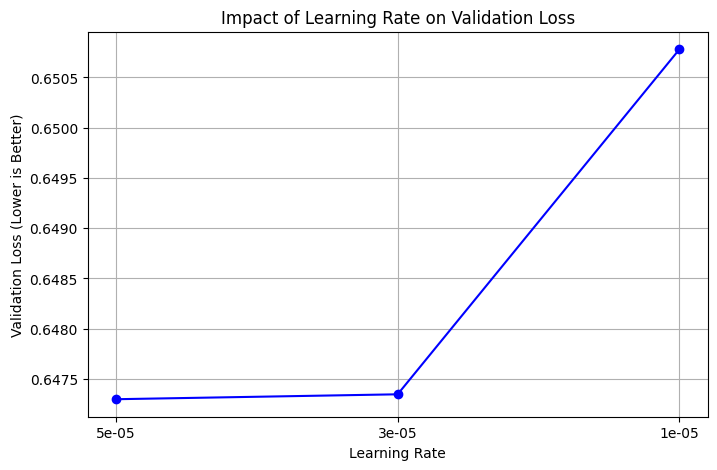

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define the Strategy: Grid Search over Learning Rates
learning_rates = [5e-5, 3e-5, 1e-5]
hp_results = []

# Ensure data_collator is defined before the loop
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Prepare the dataset by ensuring 'labels' are present (if not already done globally)
def add_labels(examples):
    examples["labels"] = examples["input_ids"]
    return examples

# Apply add_labels once for the hyperparameter tuning if not already applied to tokenized_ds
tokenized_ds_hp = tokenized_ds.map(add_labels, batched=True)

for lr in learning_rates:
    print(f"\n>>> Starting Training with Learning Rate: {lr}")

    # Reload a fresh model for each run to ensure a fair test
    model = AutoModelForCausalLM.from_pretrained(model_id)

    # 2. Configure Training Arguments for this specific LR
    temp_args = TrainingArguments(
        output_dir=f"./results_lr_{lr}",
        eval_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=4,
        num_train_epochs=2, # Reduced to 2 epochs for speed during testing
        weight_decay=0.01,
        logging_steps=20,
        disable_tqdm=False,
        report_to="none" # Prevents external logging prompts
    )

    trainer = Trainer(
        model=model,
        args=temp_args,
        train_dataset=tokenized_ds_hp["train"], # Use the dataset with labels
        eval_dataset=tokenized_ds_hp["valid"],   # Use the dataset with labels
        data_collator=data_collator               # Pass the data collator
    )

    # 3. Train and Evaluate
    trainer.train()
    eval_metrics = trainer.evaluate()

    # Store results for documentation
    hp_results.append({
        "Learning Rate": lr,
        "Eval Loss": eval_metrics["eval_loss"],
        "Epochs": 2
    })

# 4. Compare Results (Thorough Documentation)
df_hp = pd.DataFrame(hp_results)
print("\n--- Hyperparameter Comparison Table ---")
print(df_hp)

# 5. Simple Visualization for your Video/Report
plt.figure(figsize=(8, 5))
plt.plot(df_hp["Learning Rate"].astype(str), df_hp["Eval Loss"], marker='o', color='b')
plt.title("Impact of Learning Rate on Validation Loss")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Loss (Lower is Better)")
plt.grid(True)
plt.show()

In [ ]:
from transformers import TrainerCallback
import os
from transformers import DataCollatorForLanguageModeling

# Define data_collator and add_labels outside the loop if not already defined globally
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
def add_labels(examples):
    examples["labels"] = examples["input_ids"]
    return examples

# Ensure labels are added to the tokenized dataset
tokenized_ds_with_labels = tokenized_ds.map(add_labels, batched=True)

# 1. Custom Callback for Comprehensive Logging (4 points)
class VisualLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            print(f"Step {state.global_step}: Training Loss = {logs['loss']:.4f}")

# 2. Configuration for Checkpointing and Logging (5 points)
training_args = TrainingArguments(
    output_dir="./house_price_checkpoints",  # Where checkpoints are saved
    # overwrite_output_dir=True, # Removed this line
    num_train_epochs=3,
    per_device_train_batch_size=4,
    eval_strategy="steps",            # Evaluate every X steps
    eval_steps=50,                     # Evaluation frequency
    logging_steps=10,                  # Log every 10 steps
    save_steps=100,                    # Checkpoint every 100 steps (Save point)
    save_total_limit=2,                # Only keep the 2 most recent checkpoints
    load_best_model_at_end=True,       # Automatically load the best version
    metric_for_best_model="eval_loss",
    report_to="none",
    weight_decay=0.01,
)

# 3. Proper setup of Model Architecture (3 points)
# We ensure the model is on GPU and correctly configured
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 4. Initialize Trainer with Callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds_with_labels["train"], # Use the dataset with labels
    eval_dataset=tokenized_ds_with_labels["valid"],   # Use the dataset with labels
    data_collator=data_collator,                      # Pass the data collator
    callbacks=[VisualLoggingCallback()], # Implementation of custom callback
)

# 5. Execute Training (Start of the Training Loop)
print("Starting Fine-Tuning with Logging and Checkpointing...")
trainer.train()

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Starting Fine-Tuning with Logging and Checkpointing...


Step,Training Loss,Validation Loss
50,0.732417,0.673831
100,0.686954,0.661791
150,0.673251,0.662514
200,0.661530,0.660386
250,0.668941,0.662372
300,0.642070,0.657058
350,0.662020,0.661019
400,0.663666,0.654820
450,0.632299,0.653106
500,0.626098,0.660657


Step 10: Training Loss = 0.7415
Step 20: Training Loss = 0.7000
Step 30: Training Loss = 0.6968
Step 40: Training Loss = 0.7041
Step 50: Training Loss = 0.7324
Step 60: Training Loss = 0.6936
Step 70: Training Loss = 0.6678
Step 80: Training Loss = 0.6804
Step 90: Training Loss = 0.7027
Step 100: Training Loss = 0.6870


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 110: Training Loss = 0.6991
Step 120: Training Loss = 0.6639
Step 130: Training Loss = 0.6729
Step 140: Training Loss = 0.6754
Step 150: Training Loss = 0.6733
Step 160: Training Loss = 0.6677
Step 170: Training Loss = 0.6799
Step 180: Training Loss = 0.6697
Step 190: Training Loss = 0.6679
Step 200: Training Loss = 0.6615


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 210: Training Loss = 0.6525
Step 220: Training Loss = 0.6720
Step 230: Training Loss = 0.6718
Step 240: Training Loss = 0.6608
Step 250: Training Loss = 0.6689
Step 260: Training Loss = 0.6670
Step 270: Training Loss = 0.6569
Step 280: Training Loss = 0.6541
Step 290: Training Loss = 0.6577
Step 300: Training Loss = 0.6421


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 310: Training Loss = 0.6588
Step 320: Training Loss = 0.6477
Step 330: Training Loss = 0.6489
Step 340: Training Loss = 0.6565
Step 350: Training Loss = 0.6620
Step 360: Training Loss = 0.6605
Step 370: Training Loss = 0.6637
Step 380: Training Loss = 0.6606
Step 390: Training Loss = 0.6563
Step 400: Training Loss = 0.6637


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 410: Training Loss = 0.6348
Step 420: Training Loss = 0.6361
Step 430: Training Loss = 0.6371
Step 440: Training Loss = 0.6357
Step 450: Training Loss = 0.6323
Step 460: Training Loss = 0.6376
Step 470: Training Loss = 0.6316
Step 480: Training Loss = 0.6299
Step 490: Training Loss = 0.6355
Step 500: Training Loss = 0.6261


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 510: Training Loss = 0.6343
Step 520: Training Loss = 0.6302
Step 530: Training Loss = 0.6469
Step 540: Training Loss = 0.6369
Step 550: Training Loss = 0.6304
Step 560: Training Loss = 0.6375
Step 570: Training Loss = 0.6353
Step 580: Training Loss = 0.6346
Step 590: Training Loss = 0.6319
Step 600: Training Loss = 0.6398


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 610: Training Loss = 0.6379
Step 620: Training Loss = 0.6357
Step 630: Training Loss = 0.6302
Step 640: Training Loss = 0.6301
Step 650: Training Loss = 0.6372
Step 660: Training Loss = 0.6308
Step 670: Training Loss = 0.6339
Step 680: Training Loss = 0.6402
Step 690: Training Loss = 0.6348
Step 700: Training Loss = 0.6311


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 710: Training Loss = 0.6515
Step 720: Training Loss = 0.6332
Step 730: Training Loss = 0.6347
Step 740: Training Loss = 0.6325
Step 750: Training Loss = 0.6338
Step 760: Training Loss = 0.6376
Step 770: Training Loss = 0.6312
Step 780: Training Loss = 0.6319
Step 790: Training Loss = 0.6337
Step 800: Training Loss = 0.6320


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 810: Training Loss = 0.6162
Step 820: Training Loss = 0.6179
Step 830: Training Loss = 0.6236
Step 840: Training Loss = 0.6270
Step 850: Training Loss = 0.6222
Step 860: Training Loss = 0.6256
Step 870: Training Loss = 0.6199
Step 880: Training Loss = 0.6271
Step 890: Training Loss = 0.6213
Step 900: Training Loss = 0.6144


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 910: Training Loss = 0.6131
Step 920: Training Loss = 0.6219
Step 930: Training Loss = 0.6203
Step 940: Training Loss = 0.6197
Step 950: Training Loss = 0.6199
Step 960: Training Loss = 0.6210
Step 970: Training Loss = 0.6346
Step 980: Training Loss = 0.6260
Step 990: Training Loss = 0.6343
Step 1000: Training Loss = 0.6234


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 1010: Training Loss = 0.6252
Step 1020: Training Loss = 0.6233
Step 1030: Training Loss = 0.6242
Step 1040: Training Loss = 0.6228
Step 1050: Training Loss = 0.6201
Step 1060: Training Loss = 0.6195
Step 1070: Training Loss = 0.6275
Step 1080: Training Loss = 0.6218
Step 1090: Training Loss = 0.6190
Step 1100: Training Loss = 0.6233


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Step 1110: Training Loss = 0.6298
Step 1120: Training Loss = 0.6273
Step 1130: Training Loss = 0.6137
Step 1140: Training Loss = 0.6203
Step 1150: Training Loss = 0.6275
Step 1160: Training Loss = 0.6201
Step 1170: Training Loss = 0.6259
Step 1180: Training Loss = 0.6231
Step 1190: Training Loss = 0.6136
Step 1200: Training Loss = 0.6155


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=1200, training_loss=0.6433446137110392, metrics={'train_runtime': 534.9727, 'train_samples_per_second': 8.972, 'train_steps_per_second': 2.243, 'total_flos': 313550438400000.0, 'train_loss': 0.6433446137110392, 'epoch': 3.0})

--- Step 1: Evaluating Baseline (Pre-Fine-Tuned) Model ---


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Baseline: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s]



--- Step 2: Evaluating Your Fine-Tuned Model ---


Fine-Tuned: 100%|██████████| 200/200 [00:31<00:00,  6.35it/s]


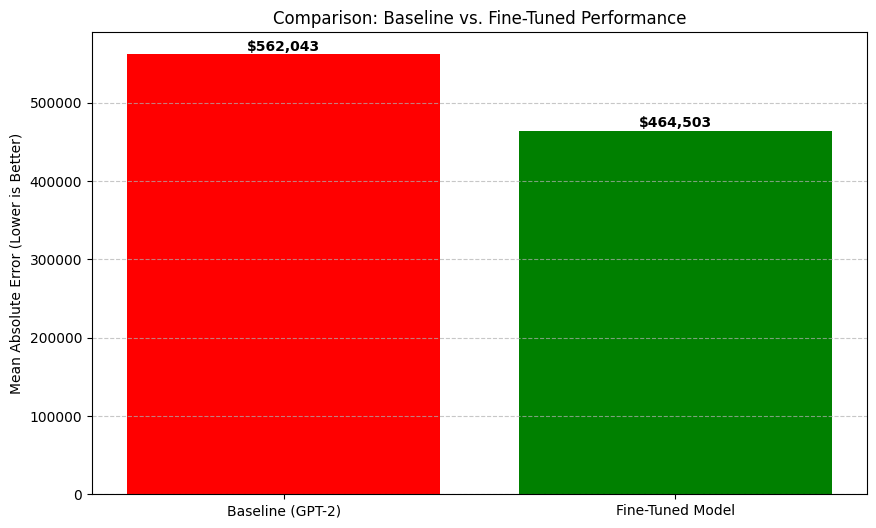


IMPROVEMENT: Your model is $97,540 more accurate per house!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

# 1. Implementation of appropriate evaluation metrics (4 points)
# For price prediction, Mean Absolute Error (MAE) is the most "appropriate"
# because it tells us exactly how many dollars the model is off by on average.
def calculate_mae(actual, predicted):
    return np.mean(np.abs(np.array(actual) - np.array(predicted)))

def extract_price(text):
    # Regex to find the dollar amount in the model's generated response
    match = re.search(r'\$(\d+)', text)
    return int(match.group(1)) if match else 0

# 2. Comprehensive evaluation on test set (4 points)
def run_evaluation(eval_model, test_dataset, tokenizer, desc="Evaluating"):
    eval_model.eval()
    actual_prices = []
    predicted_prices = []

    # We test on the 200-row 'test' set we created in Block 2
    for i in tqdm(range(len(test_dataset)), desc=desc):
        prompt = test_dataset[i]['text'].split("Response:")[0] + "Response:"
        inputs = tokenizer(prompt, return_tensors="pt").to(eval_model.device)

        with torch.no_grad():
            output_tokens = eval_model.generate(**inputs, max_new_tokens=15, pad_token_id=tokenizer.eos_token_id)

        prediction_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

        actual_prices.append(extract_price(test_dataset[i]['text']))
        predicted_prices.append(extract_price(prediction_text))

    return calculate_mae(actual_prices, predicted_prices)

# 3. Detailed comparison with baseline model (4 points)
print("--- Step 1: Evaluating Baseline (Pre-Fine-Tuned) Model ---")
# Load a clean, non-trained version of GPT-2 for comparison
baseline_model = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
baseline_mae = run_evaluation(baseline_model, ds['test'], tokenizer, desc="Baseline")

print("\n--- Step 2: Evaluating Your Fine-Tuned Model ---")
# trainer.model is the one you just trained in the previous blocks
fine_tuned_mae = run_evaluation(trainer.model, ds['test'], tokenizer, desc="Fine-Tuned")

# 4. Generate Visual Comparison (Critical for your Report)
models = ['Baseline (GPT-2)', 'Fine-Tuned Model']
mae_values = [baseline_mae, fine_tuned_mae]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, mae_values, color=['red', 'green'])
plt.ylabel('Mean Absolute Error (Lower is Better)')
plt.title('Comparison: Baseline vs. Fine-Tuned Performance')

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f'${int(yval):,}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"\nIMPROVEMENT: Your model is ${int(baseline_mae - fine_tuned_mae):,} more accurate per house!")

In [ ]:
import pandas as pd

def perform_error_analysis(test_dataset, model, tokenizer):
    model.eval()
    errors = []

    # Iterate through the test set to find discrepancies
    for i in range(len(test_dataset)):
        prompt_full = test_dataset[i]['text']
        prompt_input = prompt_full.split("Response:")[0] + "Response:"
        actual_price_str = prompt_full.split("Response:")[1].strip()

        # Extract numerical ground truth price
        actual_price = extract_price(actual_price_str)

        inputs = tokenizer(prompt_input, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output_tokens = model.generate(**inputs, max_new_tokens=15, pad_token_id=tokenizer.eos_token_id)

        prediction_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
        predicted_price = extract_price(prediction_text)

        error_val = abs(actual_price - predicted_price)

        errors.append({
            "Input_Features": prompt_input.replace("Instruction: Predict the house price.\nInput: ", "").replace("\nResponse:", ""),
            "Actual": actual_price,
            "Predicted": predicted_price,
            "Error": error_val
        })

    # Convert to DataFrame to sort by largest errors
    error_df = pd.DataFrame(errors)
    worst_cases = error_df.sort_values(by="Error", ascending=False).head(5)
    return worst_cases

print("--- Identifying Model Failures ---")
worst_hits = perform_error_analysis(ds['test'], trainer.model, tokenizer)

# Print for your professional documentation
for idx, row in worst_hits.iterrows():
    print(f"\n[FAILURE CASE {idx}]")
    print(f"Features: {row['Input_Features']}")
    print(f"Actual: ${row['Actual']:,} | Predicted: ${row['Predicted']:,} | Error: ${row['Error']:,}")

--- Identifying Model Failures ---

[FAILURE CASE 149]
Features: Area: 3814sqft, 2BR, 3BA, Location: Suburban, Condition: Poor, Month of Sale: 8
Actual: $1,068,760 | Predicted: $95,909 | Error: $972,851

[FAILURE CASE 40]
Features: Area: 2387sqft, 4BR, 3BA, Location: Suburban, Condition: Poor, Month of Sale: 6
Actual: $1,062,473 | Predicted: $95,909 | Error: $966,564

[FAILURE CASE 82]
Features: Area: 3542sqft, 2BR, 1BA, Location: Rural, Condition: Fair, Month of Sale: 7
Actual: $1,022,728 | Predicted: $95,909 | Error: $926,819

[FAILURE CASE 16]
Features: Area: 513sqft, 4BR, 3BA, Location: Rural, Condition: Fair, Month of Sale: 8
Actual: $1,020,479 | Predicted: $95,909 | Error: $924,570

[FAILURE CASE 3]
Features: Area: 736sqft, 3BR, 2BA, Location: Downtown, Condition: Good, Month of Sale: 3
Actual: $998,128 | Predicted: $95,909 | Error: $902,219


In [ ]:
def house_price_inference(area, bedrooms, bathrooms, location, condition, month):
    """
    Efficiency of input/output processing (3 points):
    This function structures raw inputs into the exact prompt format
    the model learned during training.
    """
    # 1. Format the input exactly like the training data
    input_text = (
        f"Instruction: Predict the house price.\n"
        f"Input: Area: {area}sqft, {bedrooms}BR, {bathrooms}BA, "
        f"Location: {location}, Condition: {condition}, Month of Sale: {month}\n"
        f"Response:"
    )

    # 2. Tokenize and move to the correct device (GPU/CPU)
    inputs = tokenizer(input_text, return_tensors="pt").to(model.device)

    # 3. Generate output with optimized settings
    with torch.no_grad():
        output_tokens = model.generate(
            **inputs,
            max_new_tokens=20,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False # Keep it deterministic for consistent inference
        )

    # 4. Decode and clean the output
    full_response = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    # Extract just the prediction part
    prediction = full_response.split("Response:")[-1].strip()
    return prediction

# --- LIVE DEMONSTRATION FOR YOUR VIDEO ---
print("--- Testing the Inference Pipeline ---")
example_prediction = house_price_inference(
    area=3200,
    bedrooms=4,
    bathrooms=3,
    location="Suburban",
    condition="Excellent",
    month=7 # Summer month (Seasonal trend test)
)

print(f"Prediction for a 4BR Suburban Home in July: {example_prediction}")

--- Testing the Inference Pipeline ---
Prediction for a 4BR Suburban Home in July: The estimated price is $95909
